In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("covid19bd.csv", header = 0) # dataset
df.head()

,Date,Tested,Confirmed,Isolation,Recovered,Death
0,1/5/2020,5573,571,175,14,2
1,2/5/2020,5827,552,168,3,5
2,3/5/2020,5368,665,65,886,2
3,4/5/2020,6260,688,90,147,5
4,5/5/2020,5711,786,128,193,1


In [3]:
N = 164689383

In [4]:
available = len(df.index) 
print("Available", available, "days")

Available 58 days


In [5]:
start_date = df['Date'].iloc[0]
infected = df['Confirmed'].values.tolist()
tested = df['Tested'].values.tolist()
recovered = df['Recovered'].values.tolist()
deaths = df['Death'].values.tolist()
isolation = df['Isolation'].values.tolist()
# infected = [ c - r - d for (c, r, d) in zip(confirmed, recovered, deaths)]

In [6]:
t_max = available + 7

date = np.array('2020-05-01', dtype=np.datetime64) 
dates = date + np.arange(t_max)
# print(np.arange(t_max))
str_dates = []
for i in dates:
    str_dates.append(str(i))

In [7]:
def seird_model_sd(init_vals, params, t, rho):

    DATE_0, S_0, E_0, I_0, Is_0, R_0, D_0 = init_vals
    DATE, S, E, I, Is, R, D = [DATE_0], [S_0], [E_0],[I_0], [Is_0], [R_0], [D_0]
    alpha, beta, gamma, delta, miu = params
    
    ##### Create next t days ######
    date = np.array(DATE, dtype=np.datetime64)
    dates = date + np.arange(len(t))
    str_dates = []
    for i in dates:
        str_dates.append(str(i))
        
    ##### End creating t days #####
    for tic in t[1:]:

        DATE.append(str_dates[tic])

        next_S = abs(S[-1] - ( rho*beta * (S[-1] / N) * I[-1] ))   # Susceptible
        next_E = abs(E[-1] + ( rho*beta * (S[-1] / N) * I[-1] ) - ( alpha * E[-1] ) - (miu * E[-1])) # Exposed
        next_I = abs(I[-1] + ( miu * E[-1] ) - ( gamma * I[-1] ) - ( delta * I[-1] )) # Infected
        next_Is = abs(Is[-1] + ( alpha * E[-1] )) #Isolation
        next_R = abs (R[-1] + ( gamma * I[-1] )) # Recovered
        next_D = abs (D[-1] + ( delta * I[-1] )) # Deaths
        
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        Is.append(next_Is)
        R.append(next_R)
        D.append(next_D)


    return np.stack([DATE, S, E, I, Is, R, D]).T

In [8]:
train_min = 1
train_max = available + 1

inf_train = []
rec_train = []
death_train = []
iso_train = []

for i in range(train_min+1, train_max):
    j = i - 2
    inf_train.append(infected[j:i])
    rec_train.append(recovered[j:i])
    death_train.append(deaths[j:i])
    iso_train.append(isolation[j:i])

In [9]:
vals=[]
param = []

t_incub = 7  # Assumption 7 days

for sample in range(len(inf_train)):

    i_0 = inf_train[sample][0]
    i_1 = inf_train[sample][1]
    i_diff = i_1 - i_0


    r_0 = rec_train[sample][0]
    r_1 = rec_train[sample][1]
    r_diff = r_1 - r_0


    d_0 = death_train[sample][0]
    d_1 = death_train[sample][1]
    d_diff = d_1 - d_0
    
    is_0 = iso_train[sample][0]
    is_1 = iso_train[sample][1]
    is_diff = is_1 - is_0


#     if (sample == 0):

    e_0 = (tested[sample] + isolation[sample])
    e_1 = (tested[sample+1] + isolation[sample+1])
    e_diff = e_1 - e_0
        
    s_0 = N - e_0 - i_0 - is_0 - r_0 - d_0
          

    alpha = abs((is_diff) / e_0)  # alpha
    beta = abs(( ( ( e_diff + i_diff + r_diff + d_diff+ is_diff) * N ) / ( s_0 * i_0 ) )) # beta
    gamma = abs(r_diff / i_0 ) # gamma
    delta = abs(d_diff / i_0)  # delta
    miu = abs((i_diff + r_diff + d_diff)/e_0) #miu

    init_vals = str_dates[sample], s_0, e_0, i_0, is_0, r_0, d_0
    params = alpha, beta, gamma, delta, miu
    
    vals.append(init_vals)
    param.append(params)

In [13]:
vals[46]

('2020-06-16', 164664747, 17849, 3862, 635, 2237, 53)

In [11]:
t = np.arange(0, 30, 1)

In [26]:
n = 47
# 15
# 16
# 21
# 22
# 28

infected = []
death = []
recovery=[]
isolationed=[]
susceptible = []
exposed=[]
date =[]

for rho in (1.5, 1, 0.5):
    results = seird_model_sd(vals[n], param[n], t, rho)
    t_z = t
    s=[]
    e=[]
    i=[]
    iso=[]
    r=[]
    d=[]
    dt = []
    for day in t_z:
        dt.append(results[day][0])
        s.append(int(float(results[day][1])/1))
        e.append(int(float(results[day][2])/1))
        i.append(int(float(results[day][3])/1))
        iso.append(int(float(results[day][4])/1))
        r.append(int(float(results[day][5])/1))
        d.append(int(float(results[day][6])/1))
     
    date.append(dt)
    susceptible.append(s)
    exposed.append(e)
    infected.append(i)
    isolationed.append(iso) 
    recovery.append(r)
    death.append(d)

In [24]:
# print(date)

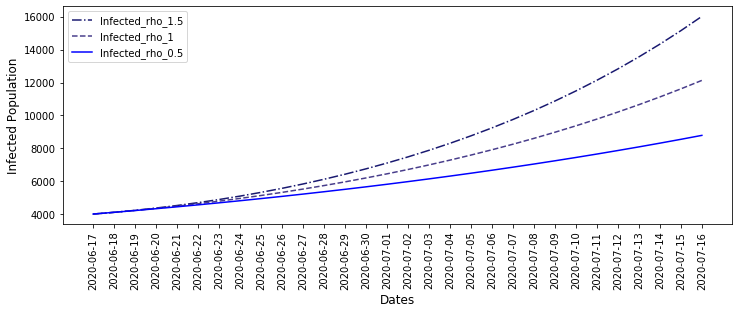

In [30]:
plt.figure(figsize=(12,4))
plt.plot(date[0], infected[0], color = 'midnightblue', label = 'Infected_rho_1.5', linestyle='-.')
plt.plot(date[1], infected[1], color = 'darkslateblue', label = 'Infected_rho_1', linestyle='--')
plt.plot(date[2], infected[2], color = 'blue', label = 'Infected_rho_0.5', linestyle='-')
# plt.plot(date[3], infected[3], color = 'darkslateblue', label = 'Infected_rho_0.5')

plt.xticks(rotation=90)

plt.xlabel("Dates", fontsize=12)
plt.ylabel("Infected Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()


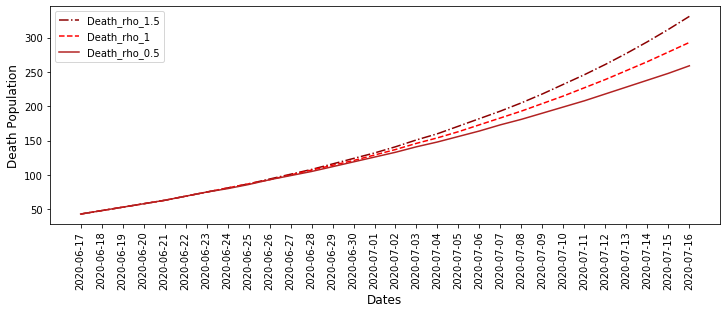

In [31]:
plt.figure(figsize=(12,4))
plt.plot(date[0], death[0], color = 'darkred', label = 'Death_rho_1.5', linestyle='-.')
plt.plot(date[1], death[1], color = 'red', label = 'Death_rho_1', linestyle='--')
plt.plot(date[2], death[2], color = 'firebrick', label = 'Death_rho_0.5', linestyle='-')
# plt.plot(date[3], death[3], color = 'indianred', label = 'Death_rho_0.5')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Death Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()


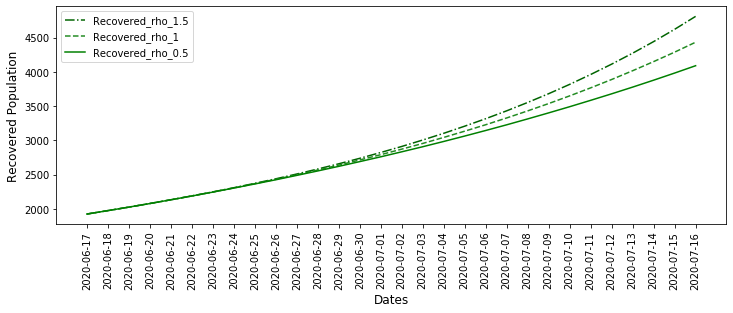

In [34]:
plt.figure(figsize=(12,4))
plt.plot(date[0], recovery[0], color = 'darkgreen', label = 'Recovered_rho_1.5', linestyle='-.')
plt.plot(date[1], recovery[1], color = 'forestgreen', label = 'Recovered_rho_1', linestyle='--')
plt.plot(date[2], recovery[2], color = 'green', label = 'Recovered_rho_0.5', linestyle='-')
# plt.plot(date[3], recovery[3], color = 'green', label = 'Recovered_rho_0.5')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Recovered Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

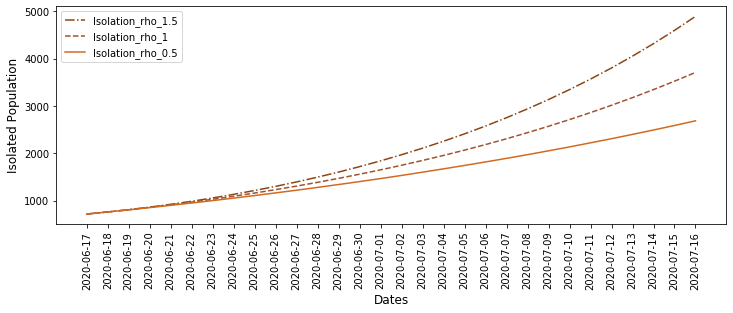

In [35]:
plt.figure(figsize=(12,4))
plt.plot(date[0], isolationed[0], color = 'saddlebrown', label = 'Isolation_rho_1.5', linestyle='-.')
plt.plot(date[1], isolationed[1], color = 'sienna', label = 'Isolation_rho_1', linestyle='--')
plt.plot(date[2], isolationed[2], color = 'chocolate', label = 'Isolation_rho_0.5', linestyle='-')
# plt.plot(date[3], isolationed[3], color = 'peru', label = 'Isolation_rho_0.5')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Isolated Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

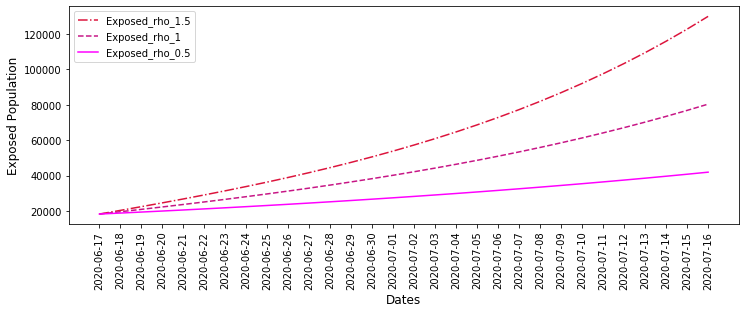

In [36]:
plt.figure(figsize=(12,4))
plt.plot(date[0], exposed[0], color = 'crimson', label = 'Exposed_rho_1.5', linestyle='-.')
plt.plot(date[1], exposed[1], color = 'mediumvioletred', label = 'Exposed_rho_1', linestyle='--')
plt.plot(date[2], exposed[2], color = 'magenta', label = 'Exposed_rho_0.5', linestyle='-')
# plt.plot(date[3], exposed[3], color = 'fuchsia', label = 'Exposed_rho_0.5')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Exposed Population", fontsize=12)

plt.legend(prop={'size':10}, loc='upper left')
plt.show()

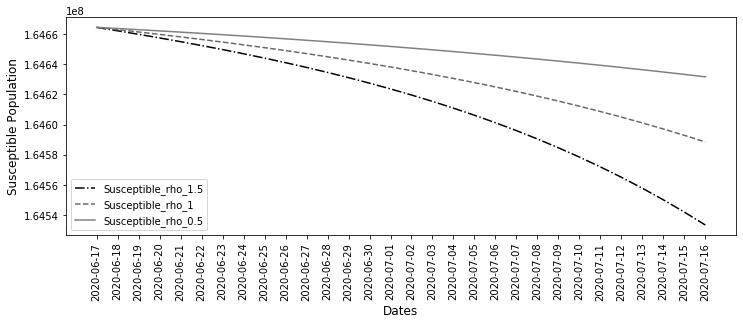

In [37]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
plt.figure(figsize=(12,4))
plt.plot(date[0], (susceptible[0]), color = 'black', label = 'Susceptible_rho_1.5', linestyle='-.')
plt.plot(date[1], susceptible[1], color = 'dimgrey', label = 'Susceptible_rho_1', linestyle='--')
plt.plot(date[2], susceptible[2], color = 'grey', label = 'Susceptible_rho_0.5', linestyle='-')
# plt.plot(date[3], susceptible[3], color = 'gray', label = 'Susceptible_rho_0.5')

plt.xticks(rotation=90)
plt.xlabel("Dates", fontsize=12)
plt.ylabel("Susceptible Population", fontsize=12)

plt.legend(prop={'size':10}, loc='lower left')
plt.show()